<a href="https://colab.research.google.com/github/alvinrach/SmartFarmingTemporaryTransit/blob/main/Multivariate_one_loss_IoTsccic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, GRU
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
!pip install PyMySQL
import json
from sqlalchemy import create_engine

# open connection to the db
json_path = '/content/drive/MyDrive/lppm-itb-iot-anomaly/paper/config_colab.json'
# json_path = './config.json'

with open(json_path) as json_file:
    config = json.load(json_file)

db_connection_str = "mysql+pymysql://{mysql_user}:{mysql_password}@{mysql_host}/{mysql_db}".format(
mysql_user = config['database']['username'], 
mysql_password = config['database']['password'],
mysql_host = config['database']['host'],
mysql_db = config['database']['databasename']
    
)
db_connection = create_engine(db_connection_str)

In [5]:
df = pd.read_sql('SELECT * FROM temp_suhus', con=db_connection)
df.head()

,id,app_id,dev_id,eui,batv,hum_sht,tempc_ds,tempc_sht,created_at,updated_at
0,1,sensecap-temperature,outdoor_temperature1,2CF7F12110700081,NaN,36.3,NaN,36.20,2020-10-16 18:55:37,2020-10-16 18:55:37
1,2,lora-lht65,lht65-1,A84041000181B265,3.064,21.0,50.00,53.61,2020-10-16 19:02:02,2020-10-16 19:02:02
2,3,lora-lht65,lht65-1,A84041000181B265,3.066,45.4,29.31,34.68,2020-10-16 19:32:02,2020-10-16 19:32:02
3,4,sensecap-temperature,outdoor_temperature1,2CF7F12110700081,NaN,71.6,NaN,25.20,2020-10-16 19:55:39,2020-10-16 19:55:39
4,5,lora-lht65,lht65-1,A84041000181B265,3.068,65.9,23.37,27.33,2020-10-16 20:02:01,2020-10-16 20:02:01


In [6]:
# convert timestamp
df['timestamp'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d %H:%M:%S')

In [7]:
df['batv'].interpolate(method='linear', direction = 'forward', inplace=True)
df['hum_sht'].interpolate(method='linear', direction = 'forward', inplace=True)
df['tempc_ds'].interpolate(method='linear', direction = 'forward', inplace=True)
df['tempc_sht'].interpolate(method='linear', direction = 'forward', inplace=True)

In [8]:
df = df.dropna()
df.isna().sum()

id            0
app_id        0
dev_id        0
eui           0
batv          0
hum_sht       0
tempc_ds      0
tempc_sht     0
created_at    0
updated_at    0
timestamp     0
dtype: int64

In [9]:
df.set_index(['timestamp'], inplace=False)

,id,app_id,dev_id,eui,batv,hum_sht,tempc_ds,tempc_sht,created_at,updated_at
timestamp,,,,,,,,,,
2020-10-16 19:02:02,2,lora-lht65,lht65-1,A84041000181B265,3.064,21.0,50.00,53.61,2020-10-16 19:02:02,2020-10-16 19:02:02
2020-10-16 19:32:02,3,lora-lht65,lht65-1,A84041000181B265,3.066,45.4,29.31,34.68,2020-10-16 19:32:02,2020-10-16 19:32:02
2020-10-16 19:55:39,4,sensecap-temperature,outdoor_temperature1,2CF7F12110700081,3.067,71.6,26.34,25.20,2020-10-16 19:55:39,2020-10-16 19:55:39
2020-10-16 20:02:01,5,lora-lht65,lht65-1,A84041000181B265,3.068,65.9,23.37,27.33,2020-10-16 20:02:01,2020-10-16 20:02:01
2020-10-16 20:32:02,6,lora-lht65,lht65-1,A84041000181B265,3.068,79.1,22.93,24.54,2020-10-16 20:32:02,2020-10-16 20:32:02
...,...,...,...,...,...,...,...,...,...,...
2021-07-19 11:21:31,35825,lora-lht65,lht65-1,A84041000181B265,3.057,47.1,34.31,38.66,2021-07-19 11:21:31,2021-07-19 11:21:31
2021-07-19 11:50:34,35826,lora-lht65,lht65-2,A84041000181B266,3.051,37.5,40.56,42.42,2021-07-19 11:50:34,2021-07-19 11:50:34
2021-07-19 11:51:15,35827,lora-lht65,lht65-3,A84041000181B267,3.054,37.2,40.50,43.38,2021-07-19 11:51:15,2021-07-19 11:51:15


In [10]:
df_ = df.resample('20Min', on='timestamp').mean()

In [11]:
df_ = df_[['batv', 'hum_sht', 'tempc_ds', 'tempc_sht']]
df_.head()

,batv,hum_sht,tempc_ds,tempc_sht
timestamp,,,,
2020-10-16 19:00:00,3.064,21.0,50.00,53.61
2020-10-16 19:20:00,3.066,45.4,29.31,34.68
2020-10-16 19:40:00,3.067,71.6,26.34,25.20
2020-10-16 20:00:00,3.068,65.9,23.37,27.33
2020-10-16 20:20:00,3.068,79.1,22.93,24.54


In [12]:
df_ = df_.dropna()

In [13]:
# key cell
df = df_.copy()

In [14]:
df

,batv,hum_sht,tempc_ds,tempc_sht
timestamp,,,,
2020-10-16 19:00:00,3.064000,21.000000,50.000000,53.610000
2020-10-16 19:20:00,3.066000,45.400000,29.310000,34.680000
2020-10-16 19:40:00,3.067000,71.600000,26.340000,25.200000
2020-10-16 20:00:00,3.068000,65.900000,23.370000,27.330000
2020-10-16 20:20:00,3.068000,79.100000,22.930000,24.540000
...,...,...,...,...
2021-07-19 10:40:00,3.051667,43.866667,35.873333,40.393333
2021-07-19 11:00:00,3.050000,52.600000,38.030000,32.900000
2021-07-19 11:20:00,3.052667,42.700000,37.850000,40.670000


In [15]:
# pca = PCA(n_components=3)
# principalComponents = pca.fit_transform(df)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3'])

pca = PCA(n_components=4)
principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3', 'pc4'])

In [16]:
n_pcs= pca.components_.shape[0]
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = list(df.columns)
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
principalDf = df[most_important_names]
most_important_names

['hum_sht', 'tempc_sht', 'tempc_ds', 'batv']

In [17]:
train_data, test_data = train_test_split(principalDf, shuffle=False, test_size=0.3)

In [18]:
scaler = MinMaxScaler()
scaler.fit(principalDf)
X_trainset = scaler.transform(train_data)
X_testset = scaler.transform(test_data)

In [19]:
X_trainset = pd.DataFrame(X_trainset)
X_testset = pd.DataFrame(X_testset)

In [20]:
epo = 60

In [21]:
TIME_STEPS=3

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(X_trainset, X_trainset.iloc[:,0])
X_test, y_test = create_sequences(X_testset, X_testset.iloc[:,0])

In [22]:
def gru_model(X):
  model = Sequential()
  model.add(GRU(16, input_shape=(X.shape[1], X.shape[2])))
  model.add(Dense(1))
  return model

In [23]:
y_train = y_train.reshape(-1,1)

In [24]:
y_test = y_test.reshape(-1,1)

In [25]:
model = gru_model(X_train)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 16)                1056      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,073
Trainable params: 1,073
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [26]:
nb_epochs = epo
batch_size = 32
history = model.fit(X_train, y_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test), shuffle=False).history

Epoch 1/60
318/318 [==============================] - 4s 6ms/step - loss: 3.5323e-04 - val_loss: 2.3481e-04
Epoch 2/60
318/318 [==============================] - 1s 4ms/step - loss: 1.2792e-04 - val_loss: 2.3263e-04
Epoch 3/60
318/318 [==============================] - 2s 5ms/step - loss: 1.1177e-04 - val_loss: 2.3242e-04
Epoch 4/60
318/318 [==============================] - 1s 4ms/step - loss: 1.0902e-04 - val_loss: 2.3237e-04
Epoch 5/60
318/318 [==============================] - 2s 5ms/step - loss: 1.0889e-04 - val_loss: 2.3463e-04
Epoch 6/60
318/318 [==============================] - 1s 5ms/step - loss: 1.0925e-04 - val_loss: 2.3946e-04
Epoch 7/60
318/318 [==============================] - 1s 4ms/step - loss: 1.0947e-04 - val_loss: 2.4569e-04
Epoch 8/60
318/318 [==============================] - 1s 4ms/step - loss: 1.0960e-04 - val_loss: 2.5089e-04
Epoch 9/60
318/318 [==============================] - 1s 4ms/step - loss: 1.0976e-04 - val_loss: 2.5349e-04
Epoch 10/60
318/318 [=======

In [27]:
a = model.predict(X_train)
b = model.predict(X_test)
y_train_1 = y_train.copy()
y_test_1 = y_test.copy()

X_pred_tr = a.copy()
X_pred_ts = b.copy()

In [28]:
TIME_STEPS=3

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(X_trainset, X_trainset.iloc[:,1])
X_test, y_test = create_sequences(X_testset, X_testset.iloc[:,1])

def gru_model(X):
  model = Sequential()
  model.add(GRU(16, input_shape=(X.shape[1], X.shape[2])))
  model.add(Dense(1))
  return model

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

model = gru_model(X_train)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='mse')
model.summary()

nb_epochs = epo
batch_size = 32
history = model.fit(X_train, y_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test), shuffle=False).history

a = model.predict(X_train)
b = model.predict(X_test)
y_train_1 = np.hstack((y_train_1, y_train))
y_test_1 = np.hstack((y_test_1, y_test))

X_pred_tr = np.hstack((X_pred_tr,a))
X_pred_ts = np.hstack((X_pred_ts,b))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 16)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,073
Trainable params: 1,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
318/318 [==============================] - 4s 6ms/step - loss: 0.0013 - val_loss: 2.9876e-04
Epoch 2/60
318/318 [==============================] - 2s 5ms/step - loss: 2.8783e-04 - val_loss: 2.0114e-04
Epoch 3/60
318/318 [==============================] - 2s 5ms/step - loss: 2.9299e-04 - val_loss: 1.9082e-04
Epoch 4/60
318/318 [==============================] - 1s 4ms/step - loss: 2.9825e-04 - val_loss: 1.8638e-04
Epoch 5/60
318/318 [==============================] - 1s 4ms/step - loss: 2.9656e-04 -

In [29]:
TIME_STEPS=3

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(X_trainset, X_trainset.iloc[:,2])
X_test, y_test = create_sequences(X_testset, X_testset.iloc[:,2])

def gru_model(X):
  model = Sequential()
  model.add(GRU(16, input_shape=(X.shape[1], X.shape[2])))
  model.add(Dense(1))
  return model

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

model = gru_model(X_train)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='mse')
model.summary()

nb_epochs = epo
batch_size = 32
history = model.fit(X_train, y_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test), shuffle=False).history

a = model.predict(X_train)
b = model.predict(X_test)
y_train_1 = np.hstack((y_train_1, y_train))
y_test_1 = np.hstack((y_test_1, y_test))

X_pred_tr = np.hstack((X_pred_tr,a))
X_pred_ts = np.hstack((X_pred_ts,b))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 16)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,073
Trainable params: 1,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
318/318 [==============================] - 4s 6ms/step - loss: 0.0023 - val_loss: 5.2318e-04
Epoch 2/60
318/318 [==============================] - 2s 5ms/step - loss: 4.2027e-04 - val_loss: 2.7253e-04
Epoch 3/60
318/318 [==============================] - 2s 5ms/step - loss: 3.7360e-04 - val_loss: 2.4759e-04
Epoch 4/60
318/318 [==============================] - 2s 5ms/step - loss: 3.7017e-04 - val_loss: 2.3190e-04
Epoch 5/60
318/318 [==============================] - 1s 5ms/step - loss: 3.6327e-04 -

In [30]:
TIME_STEPS=3

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(X_trainset, X_trainset.iloc[:,3])
X_test, y_test = create_sequences(X_testset, X_testset.iloc[:,3])

def gru_model(X):
  model = Sequential()
  model.add(GRU(16, input_shape=(X.shape[1], X.shape[2])))
  model.add(Dense(1))
  return model

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

model = gru_model(X_train)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='mse')
model.summary()

nb_epochs = epo
batch_size = 32
history = model.fit(X_train, y_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test), shuffle=False).history

a = model.predict(X_train)
b = model.predict(X_test)
y_train_1 = np.hstack((y_train_1, y_train))
y_test_1 = np.hstack((y_test_1, y_test))

X_pred_tr = np.hstack((X_pred_tr,a))
X_pred_ts = np.hstack((X_pred_ts,b))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 16)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,073
Trainable params: 1,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
318/318 [==============================] - 4s 6ms/step - loss: 0.0379 - val_loss: 0.0069
Epoch 2/60
318/318 [==============================] - 2s 5ms/step - loss: 0.0064 - val_loss: 0.0046
Epoch 3/60
318/318 [==============================] - 2s 5ms/step - loss: 0.0044 - val_loss: 0.0030
Epoch 4/60
318/318 [==============================] - 2s 5ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 5/60
318/318 [==============================] - 2s 5ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 6/60
318

In [31]:
# Key cell

X_pred = X_pred_ts
y_test = scaler.inverse_transform(y_test_1)

# X_pred = X_pred_tr
# y_train = scaler.inverse_transform(y_train_1)

In [32]:
X_prediction = scaler.inverse_transform(X_pred)
# X_prediction = X_pred
output = pd.DataFrame(X_prediction, columns = most_important_names)
output

,hum_sht,tempc_sht,tempc_ds,batv
0,98.058998,20.645935,20.498039,3.040270
1,97.411522,20.654930,20.480862,3.040091
2,98.885933,20.452024,20.592705,3.044140
3,97.964058,20.583363,20.411846,3.039209
4,97.626305,20.615610,20.580553,3.040540
...,...,...,...,...
4348,55.886089,38.410328,36.252216,3.052506
4349,56.325615,35.435863,34.994728,3.053005
4350,53.843067,38.472504,35.802322,3.052316
4351,50.113110,39.977177,36.409046,3.052392


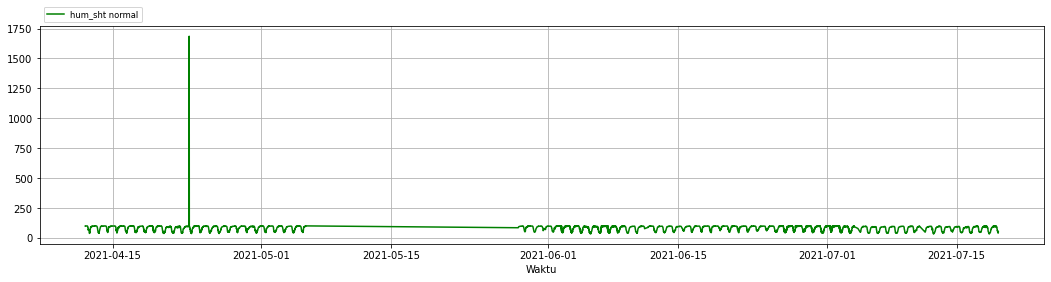

In [33]:
most_important_names
feat = most_important_names[0]
 
plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='green', label='{} normal'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

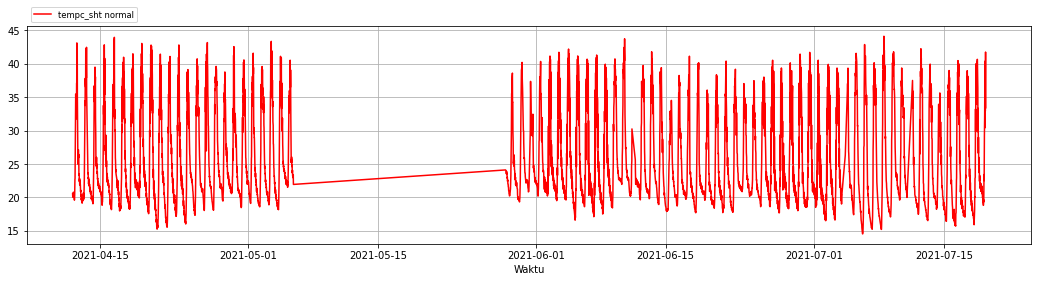

In [34]:
most_important_names
feat = most_important_names[1]
 
plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='red', label='{} normal'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

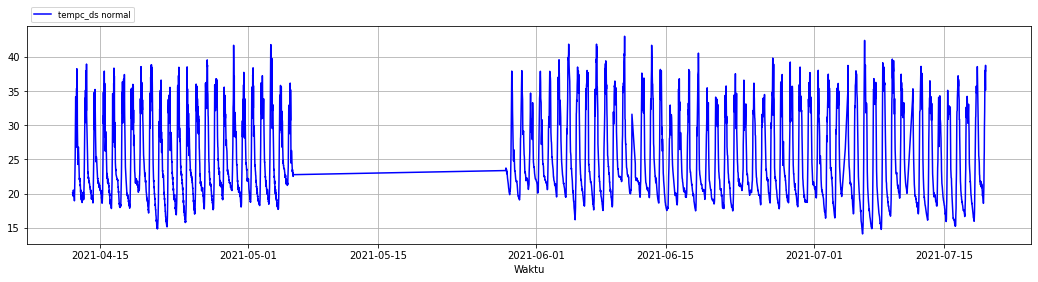

In [35]:
most_important_names
feat = most_important_names[2]
 
plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='blue', label='{} normal'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

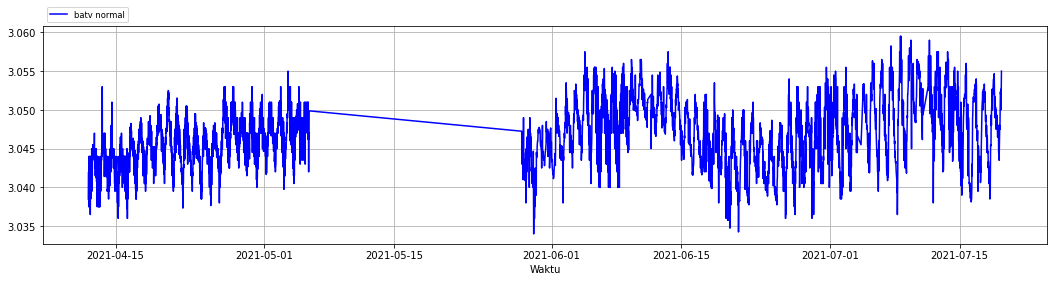

In [36]:
most_important_names
feat = most_important_names[3]
 
plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='blue', label='{} normal'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

In [37]:
output.index = test_data[3:].index

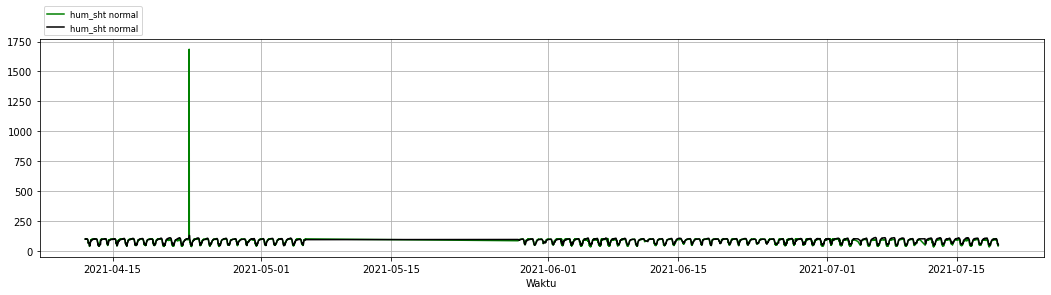

In [38]:
most_important_names
feat = most_important_names[0]
 
plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='green', label='{} normal'.format(feat))
plt.plot(output[feat], color='black', label='{} normal'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

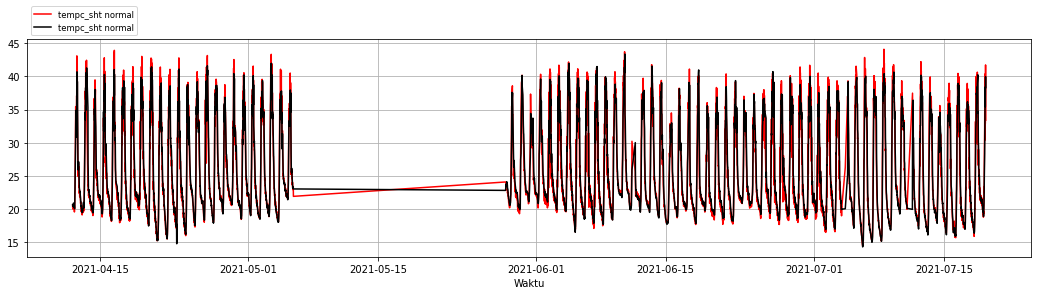

In [39]:
most_important_names
feat = most_important_names[1]
 
plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='red', label='{} normal'.format(feat))
plt.plot(output[feat], color='black', label='{} normal'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

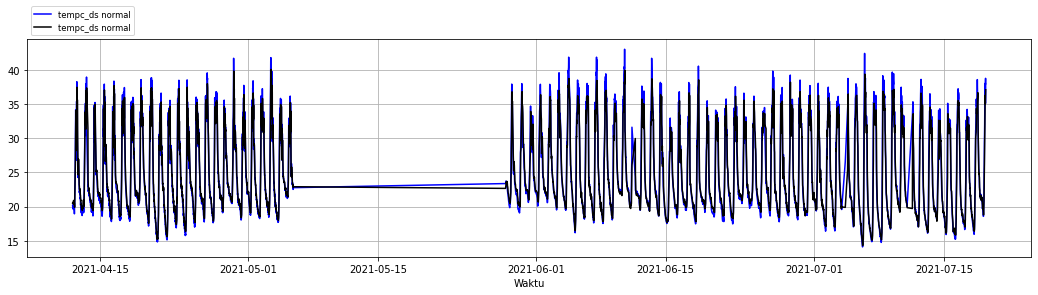

In [40]:
most_important_names
feat = most_important_names[2]
 
plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='blue', label='{} normal'.format(feat))
plt.plot(output[feat], color='black', label='{} normal'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

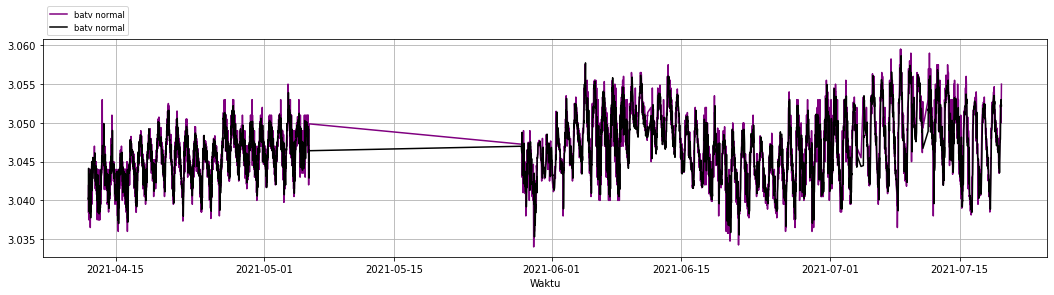

In [41]:
most_important_names
feat = most_important_names[3]
 
plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='purple', label='{} normal'.format(feat))
plt.plot(output[feat], color='black', label='{} normal'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

In [58]:
most_important_names
feat = most_important_names[0]

data = pd.DataFrame(index=test_data.index)
data = data[3:]

data['Threshold'] = 5
data['Loss_mae_test'] = np.mean(np.abs(output-y_test), axis = 1)
# data['Loss_mae_test'] = np.abs(output-y_test)[feat]
data['Anomaly'] = data['Loss_mae_test'] > data['Threshold']
data = pd.concat((data, test_data[3:]),1)

In [59]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Loss_mae_test'], name='Test loss'))
fig.add_trace(go.Scatter(x=data.index, y=data['Threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold -  {}'.format(feat))
fig.show()

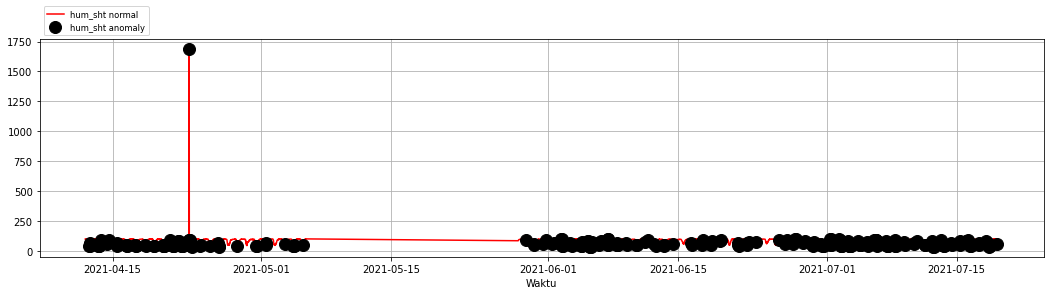

In [60]:
data = data.loc[data["Anomaly"] == True]

plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='red', label='{} normal'.format(feat))
plt.plot(data[feat], linestyle='none', marker='o', color='black', markersize=12, label='{} anomaly'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

In [61]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_data.index[3:], y=test_data[3:][feat], name='{} normal'.format(feat)))
fig.add_trace(go.Scatter(x=data.index, y=data[feat], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies - {}'.format(feat))
fig.show()

In [62]:
most_important_names
feat = most_important_names[1]

data = pd.DataFrame(index=test_data.index)
data = data[3:]

data['Threshold'] = 5
data['Loss_mae_test'] = np.mean(np.abs(output-y_test), axis = 1)
# data['Loss_mae_test'] = np.abs(output-y_test)[feat]
data['Anomaly'] = data['Loss_mae_test'] > data['Threshold']
data = pd.concat((data, test_data[3:]),1)

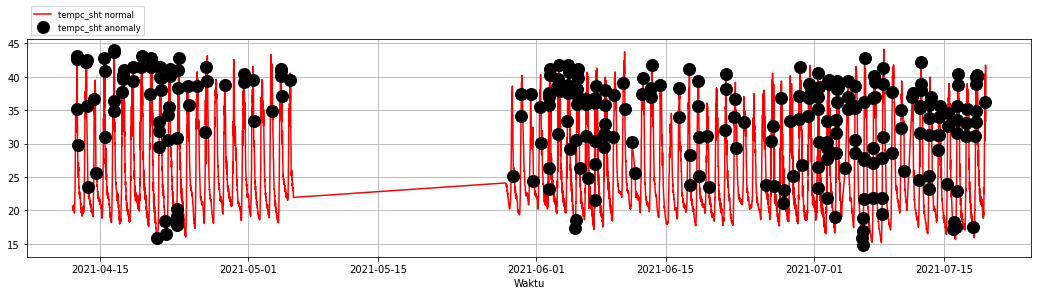

In [64]:
data = data.loc[data["Anomaly"] == True]

plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='red', label='{} normal'.format(feat))
plt.plot(data[feat], linestyle='none', marker='o', color='black', markersize=12, label='{} anomaly'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

In [65]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_data.index[3:], y=test_data[3:][feat], name='{} normal'.format(feat)))
fig.add_trace(go.Scatter(x=data.index, y=data[feat], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies - {}'.format(feat))
fig.show()

In [66]:
most_important_names
feat = most_important_names[2]

data = pd.DataFrame(index=test_data.index)
data = data[3:]

data['Threshold'] = 5
data['Loss_mae_test'] = np.mean(np.abs(output-y_test), axis = 1)
# data['Loss_mae_test'] = np.abs(output-y_test)[feat]
data['Anomaly'] = data['Loss_mae_test'] > data['Threshold']
data = pd.concat((data, test_data[3:]),1)

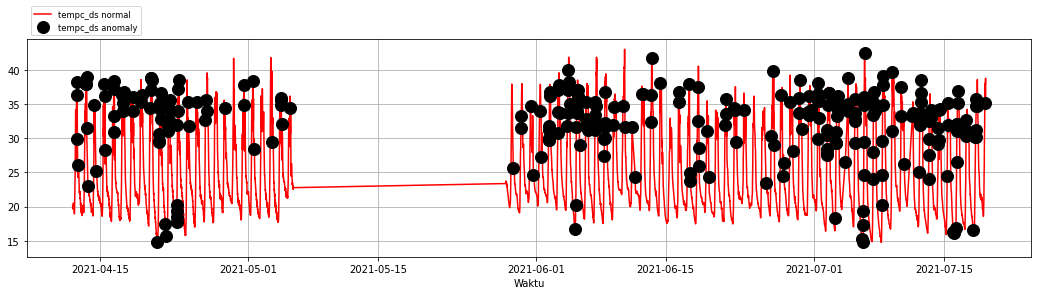

In [68]:
data = data.loc[data["Anomaly"] == True]

plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='red', label='{} normal'.format(feat))
plt.plot(data[feat], linestyle='none', marker='o', color='black', markersize=12, label='{} anomaly'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

In [69]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_data.index[3:], y=test_data[3:][feat], name='{} normal'.format(feat)))
fig.add_trace(go.Scatter(x=data.index, y=data[feat], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies - {}'.format(feat))
fig.show()

In [70]:
most_important_names
feat = most_important_names[3]

data = pd.DataFrame(index=test_data.index)
data = data[3:]

data['Threshold'] = 5
data['Loss_mae_test'] = np.mean(np.abs(output-y_test), axis = 1)
# data['Loss_mae_test'] = np.abs(output-y_test)[feat]
data['Anomaly'] = data['Loss_mae_test'] > data['Threshold']
data = pd.concat((data, test_data[3:]),1)

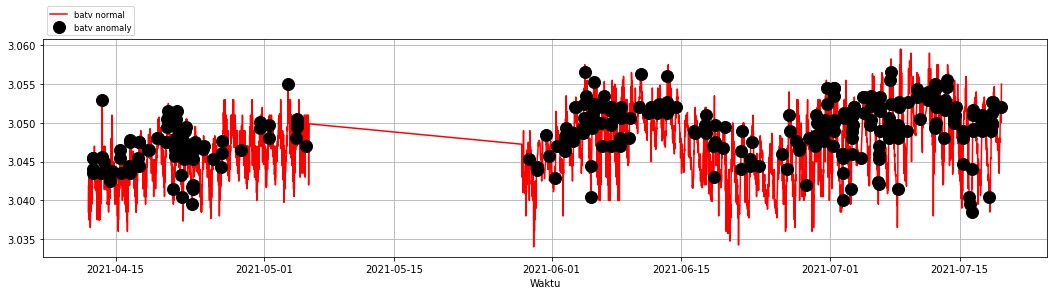

In [72]:
data = data.loc[data["Anomaly"] == True]

plt.figure(figsize=(18,4))
plt.plot(test_data[3:][feat], color='red', label='{} normal'.format(feat))
plt.plot(data[feat], linestyle='none', marker='o', color='black', markersize=12, label='{} anomaly'.format(feat))
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.show()

In [73]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_data.index[3:], y=test_data[3:][feat], name='{} normal'.format(feat)))
fig.add_trace(go.Scatter(x=data.index, y=data[feat], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies - {}'.format(feat))
fig.show()